# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to push the car to the mountaintop on the right.

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0.6 & 0 
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The initial position is within $[-0.6, -0.4]$.

In [1]:
%matplotlib inline

import importlib


In [2]:
from __future__ import print_function
import sys
import os
sys.path.append(os.path.abspath('../'))
import random
import ilqr
import math

In [3]:
import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt


In [14]:
from ilqr import iLQR
from ilqr.cost import PathQRCost, QRCost
from ilqr.examples.car import CarDynamics, MountaincarDynamics, CarCost
from ilqr.dynamics import constrain

from bc import *
import pickle
import gym

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = dynamics.reduce_state(xs[-1])
    if iteration_count % 30 == 0:
        print("iteration", iteration_count, info, J_opt, final_state)

In [7]:
env = gym.make('MountainCar-v0')

importlib.reload(ilqr)
dynamics = MountaincarDynamics()


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [8]:

def goal():
    return np.array([0.6, 0.0])

def barrier_u(x):
    return np.array([0.5, 0.07])
                                                                      
def barrier_l(x):
    return np.array([-1.1, -0.01])

def nominal():
    return np.array([0.6, 0.0])


In [9]:
# Instantenous state cost.
x_goal = goal()

Q = np.eye(dynamics.state_size)
Q[0, 0] = 10.0
Q[1, 1] = 0.0
# Terminal state cost.
Q_terminal = 100 * np.eye(dynamics.state_size)

# Instantaneous control cost.
R = np.array([[0.1]])

cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=goal())


In [10]:
N = 200
x0 = env.reset()
us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost, N)

In [11]:
J_hist = []

iteration 0 accepted 5193.614586010163 [-0.9760202   0.00262743]


In [22]:
env.close()
state = env.reset()
reward = 0.0
done = False

step_len = 200
n = 200
n_iterations = 1000
for step in range(int(200/len_seq)): 
    x0 = dynamics.augment_state(state)
    us_init = np.random.uniform(-1, 1, (n , dynamics.action_size))
    ilqr = iLQR(dynamics, cost, n)
    xs, us = ilqr.fit(x0, us_init, n_iterations = n_iterations, on_iteration=on_iteration)
    us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)
    us = us[0: len_seq]
    us = (us > 0.0).astype(int)
    for i_step in range(len_seq):
        u = us[i_step][0]
        print(step * len_seq + i_step, state, u, reward, done)
        state, reward, done, _ = env.step(u)
        env.render()
        if done is True:
            raise ValueError('Done')

iteration 0 accepted 5193.686886257471 [-0.9760202   0.00262743]
0 [-0.57182194  0.        ] 1 0.0 False
1 [-5.71461522e-01  3.60413427e-04] 1 -1.0 False
2 [-0.57074337  0.00071815] 1 -1.0 False
3 [-0.56967281  0.00107056] 1 -1.0 False
4 [-0.5682578   0.00141501] 1 -1.0 False
5 [-0.56650884  0.00174896] 1 -1.0 False
6 [-0.56443895  0.00206989] 1 -1.0 False
7 [-0.56206352  0.00237543] 1 -1.0 False
8 [-0.55940024  0.00266327] 1 -1.0 False
9 [-0.55646897  0.00293127] 1 -1.0 False
10 [-0.55329158  0.0031774 ] 1 -1.0 False
11 [-0.54989178  0.0033998 ] 1 -1.0 False
12 [-0.54629499  0.00359679] 1 -1.0 False
13 [-0.5425281   0.00376688] 1 -1.0 False
14 [-0.53861933  0.00390878] 1 -1.0 False
15 [-0.53459794  0.00402139] 1 -1.0 False
16 [-0.53049407  0.00410387] 1 -1.0 False
17 [-0.52633849  0.00415558] 1 -1.0 False
18 [-0.52216236  0.00417613] 1 -1.0 False
19 [-0.517997    0.00416536] 1 -1.0 False
20 [-0.51387366  0.00412334] 1 -1.0 False
21 [-0.50982324  0.00405042] 1 -1.0 False
22 [-0.5058761

193 [-0.49886103 -0.00348944] 1 -1.0 False
194 [-0.50253583 -0.00367481] 1 -1.0 False
195 [-0.50636851 -0.00383267] 1 -1.0 False
196 [-0.51033035 -0.00396184] 1 -1.0 False
197 [-0.51439168 -0.00406133] 1 -1.0 False
198 [-0.51852205 -0.00413037] 1 -1.0 False
199 [-0.5226905  -0.00416845] 0 -1.0 False


ValueError: Done

In [12]:
N = len(x_path)
n = 30  # Number of time steps in trajectory.
J_hist = []
expert_traj = []

x0 = x_path[0]  # Initial state.
# Random initial action path.
#us_init = np.random.uniform(-1, 1, (n - 1, dynamics.action_size))
us_init = np.zeros((n - 1, dynamics.action_size))

for i in range(0, int(N - n) + 1):
    k = 3
    if i % k != 0:
        continue
        #pass
    x_path_ = x_path[i: i + n]
    cost = CarCost(Q = Q, q = q, R = R, r = r, A = A, b = b, q1 = q1, q2 = q2,\
                   x_nominal = x_path_,\
                   x_barrier_u = barrier_u,\
                   x_barrier_l = barrier_l)
    ilqr = iLQR(dynamics, cost, n - 1)
    xs, us = ilqr.fit(x0, us_init, on_iteration=on_iteration)

    x0 = xs[k][:]
    expert_traj = expert_traj + [[xs[i], us[i]] for i in range(k)]
    
    
    

NameError: name 'x_path' is not defined

In [10]:
# Reduce the state to something more reasonable.
xs = dynamics.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)

In [11]:
t = np.arange(N + 1) * dt
x = xs[:, 0]
x_dot = xs[:, 1]
theta = np.unwrap(xs[:, 2])  # Makes for smoother plots.
theta_dot = xs[:, 3]

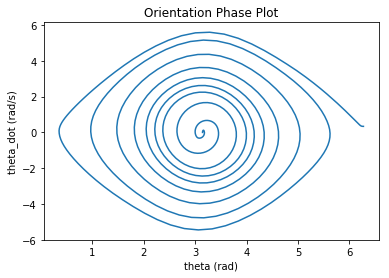

In [12]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Orientation Phase Plot")
plt.show()

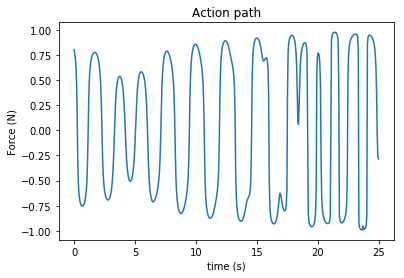

In [14]:
_ = plt.plot(t[:-1], us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

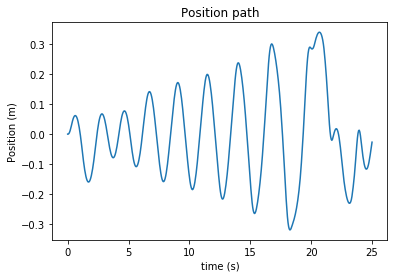

In [15]:
_ = plt.plot(t, x)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Position (m)")
_ = plt.title("Position path")

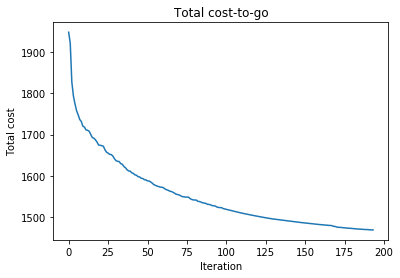

In [17]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
iteration 0 accepted 5185.9280363679645 [-0.9760202   0.00262743]
0 [-0.44596129  0.        ] 1 0.0 False
1 [-0.44653832 -0.00057703] 1 -1.0 False
2 [-0.44768817 -0.00114985] 1 -1.0 False
3 [-0.44940244 -0.00171427] 1 -1.0 False
4 [-0.4516686  -0.00226616] 1 -1.0 False
5 [-0.45447006 -0.00280146] 1 -1.0 False
6 [-0.45778628 -0.00331622] 1 -1.0 False
7 [-0.46159289 -0.00380661] 1 -1.0 False
8 [-0.46586186 -0.00426898] 1 -1.0 False
9 [-0.4705617  -0.00469984] 1 -1.0 False
iteration 0 accepted 5187.820371149795 [-0.9760202   0.00262743]
10 [-0.47565764 -0.00509594] 1 -1.0 False
11 [-0.48111191 -0.00545426] 1 -1.0 False
12 [-0.48688396 -0.00577205] 1 -1.0 False
13 [-0.49293082 -0.00604686] 1 -1.0 False
14 [-0.49920736 -0.00627654] 1 -1.0 False
15 [-0.50566667 -0.00645931] 1 -1.0 False
16 [-0.51226041 -0.00659374] 1 -1.0 False
17 [-0.51893917 -0.00667876] 1 -1.0 False
18 [-0.52565288 -0.006713

165 [-0.53532596 -0.00667516] 1 -1.0 False
166 [-0.54191319 -0.00658722] 1 -1.0 False
167 [-0.54836312 -0.00644994] 1 -1.0 False
168 [-0.5546275  -0.00626437] 1 -1.0 False
169 [-0.56065949 -0.00603199] 1 -1.0 False
iteration 0 accepted 5193.386392042774 [-0.9760202   0.00262743]
170 [-0.5664141  -0.00575461] 1 -1.0 False
171 [-0.57184848 -0.00543438] 1 -1.0 False
172 [-0.57692225 -0.00507377] 1 -1.0 False
173 [-0.58159779 -0.00467555] 1 -1.0 False
174 [-0.58584054 -0.00424274] 1 -1.0 False
175 [-0.58961917 -0.00377864] 1 -1.0 False
176 [-0.59290589 -0.00328672] 1 -1.0 False
177 [-0.59567654 -0.00277065] 1 -1.0 False
178 [-0.59791081 -0.00223427] 1 -1.0 False
179 [-0.59959235 -0.00168154] 1 -1.0 False
iteration 0 accepted 5195.411343313821 [-0.9760202   0.00262743]
180 [-0.60070886 -0.00111651] 1 -1.0 False
181 [-6.01252182e-01 -5.43326569e-04] 1 -1.0 False
182 [-6.01218362e-01  3.38203974e-05] 1 -1.0 False
183 [-0.60060764  0.00061072] 1 -1.0 False
184 [-0.59942448  0.00118316] 1 -1.0 

ValueError: Done